In [4]:
%load_ext autoreload
%autoreload 2

from bayesflow import benchmarks, diagnostics, trainers
from bayesflow.experimental.free_form_flows import FFFAmortizedPosterior, FFFHParams, FFFNetwork

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Quickstart: Free-form flows for simulation-based inference

Here, we integrate the free-form flow (FFF) loss from Draxler et al. 2023 (arXiv:2310.16624) inthe Bayesflow training routine.
This loss computational efficiently estimates of the gradient of the negative log likelihood (NLL) loss for any network architecture. This overcomes the architectural restrictions of the invertible neural networks used in Bayesflow, which rely on coupling layers of neural ODEs for feasible training. Instead, we can use an encoder and decoder network of arbitrary architecture and even combine summary and inference network into one. The new loss is implemented in a custom amortizer (FFFAmortizer). Similar to the sbi experiments in the original free-form flow paper, we use networks with a combination of fully and resnet layers.

In [5]:
benchmark_name = 'gaussian_linear'

training_config = {
    'epochs': 100,
    'iterations': 50,
    'batch_size': 512,
    'validation_sims': 100,
}

n_observations = 100
n_samples = 1000
n_latent = 10000

# hyper parameters for the FFF network
hparams = FFFHParams({
    'activation': 'silu',
    'num_dense_layers': 2,
    'num_resnet_layers': 2,
    'units': 256
}
)

Training with the FFF loss introduces a new hyperparameter $\beta$. The FFF loss consists of two parts $\mathcal{L}_{FFF} = \mathcal{L}_{NLL} + \beta * \mathcal{L}_{recon.}$.

The first term is the approximate NLL loss and the second one a reconstruction loss to ensure invertibility of the encoder and decoder architecture. For more details on the theory, please see the original publication.

In practice, good choices for $\beta$ are in the range of 2 - 1000.

In [11]:
benchmark = benchmarks.Benchmark(benchmark_name, 'posterior')

sample = benchmark.configurator(benchmark.generative_model(2))
hparams['data_dim'] = 10
hparams['cond_dim'] = 10
hparams['latent_dim'] = 10

fully = FFFNetwork(hparams)
amortizer = FFFAmortizedPosterior(inference_net = fully, beta = 10, surrogate=True, memorize_last_samples=True) # training with the exact negative log likelihood is possible but unfeasible for more complex problems

trainer = trainers.Trainer(
    amortizer=amortizer,
    generative_model=benchmark.generative_model,
    learning_rate=1e-3,
    configurator=benchmark.configurator,
    memory=False,
)

h = trainer.train_online(epochs=training_config['epochs'], iterations_per_epoch=training_config['iterations'], batch_size=training_config['batch_size'], validation_sims=training_config['validation_sims'])

INFO:root:Performing 2 pilot runs with the gaussian_linear model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 10)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 10)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
INFO:root:Generated 100 simulations for validation.


Training epoch 1:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, nll: 14.041, reconstruction_loss: 0.319


Training epoch 2:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, nll: 2.589, reconstruction_loss: 0.237


Training epoch 3:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, nll: -2.684, reconstruction_loss: 0.161


Training epoch 4:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, nll: -5.182, reconstruction_loss: 0.099


Training epoch 5:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, nll: -8.999, reconstruction_loss: 0.081


Training epoch 6:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, nll: -12.230, reconstruction_loss: 0.052


Training epoch 7:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, nll: -12.309, reconstruction_loss: 0.008


Training epoch 8:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, nll: -12.332, reconstruction_loss: 0.005


Training epoch 9:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, nll: -12.305, reconstruction_loss: 0.007


Training epoch 10:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, nll: -12.331, reconstruction_loss: 0.008


Training epoch 11:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, nll: -12.298, reconstruction_loss: 0.007


Training epoch 12:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, nll: -12.293, reconstruction_loss: 0.006


Training epoch 13:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, nll: -12.287, reconstruction_loss: 0.006


Training epoch 14:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, nll: -12.305, reconstruction_loss: 0.006


Training epoch 15:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, nll: -12.294, reconstruction_loss: 0.006


Training epoch 16:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, nll: -12.321, reconstruction_loss: 0.006


Training epoch 17:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, nll: -12.292, reconstruction_loss: 0.004


Training epoch 18:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, nll: -12.298, reconstruction_loss: 0.005


Training epoch 19:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, nll: -12.288, reconstruction_loss: 0.005


Training epoch 20:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, nll: -12.306, reconstruction_loss: 0.006


Training epoch 21:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, nll: -12.328, reconstruction_loss: 0.005


Training epoch 22:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, nll: -12.342, reconstruction_loss: 0.006


Training epoch 23:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, nll: -12.344, reconstruction_loss: 0.004


Training epoch 24:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, nll: -12.314, reconstruction_loss: 0.003


Training epoch 25:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, nll: -12.348, reconstruction_loss: 0.004


Training epoch 26:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, nll: -12.290, reconstruction_loss: 0.004


Training epoch 27:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, nll: -12.310, reconstruction_loss: 0.005


Training epoch 28:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, nll: -12.316, reconstruction_loss: 0.004


Training epoch 29:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, nll: -12.270, reconstruction_loss: 0.003


Training epoch 30:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, nll: -12.293, reconstruction_loss: 0.002


Training epoch 31:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, nll: -12.318, reconstruction_loss: 0.005


Training epoch 32:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, nll: -12.292, reconstruction_loss: 0.004


Training epoch 33:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, nll: -12.304, reconstruction_loss: 0.005


Training epoch 34:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, nll: -12.313, reconstruction_loss: 0.002


Training epoch 35:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, nll: -12.305, reconstruction_loss: 0.003


Training epoch 36:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, nll: -12.351, reconstruction_loss: 0.002


Training epoch 37:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, nll: -12.309, reconstruction_loss: 0.002


Training epoch 38:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, nll: -12.314, reconstruction_loss: 0.002


Training epoch 39:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, nll: -12.290, reconstruction_loss: 0.003


Training epoch 40:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, nll: -12.306, reconstruction_loss: 0.002


Training epoch 41:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, nll: -12.301, reconstruction_loss: 0.004


Training epoch 42:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, nll: -12.335, reconstruction_loss: 0.003


Training epoch 43:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, nll: -12.300, reconstruction_loss: 0.002


Training epoch 44:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, nll: -12.361, reconstruction_loss: 0.002


Training epoch 45:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, nll: -12.351, reconstruction_loss: 0.002


Training epoch 46:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, nll: -12.311, reconstruction_loss: 0.003


Training epoch 47:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, nll: -12.328, reconstruction_loss: 0.002


Training epoch 48:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, nll: -12.337, reconstruction_loss: 0.002


Training epoch 49:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, nll: -12.323, reconstruction_loss: 0.001


Training epoch 50:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, nll: -12.326, reconstruction_loss: 0.001


Training epoch 51:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 51, nll: -12.348, reconstruction_loss: 0.001


Training epoch 52:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 52, nll: -12.320, reconstruction_loss: 0.001


Training epoch 53:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 53, nll: -12.346, reconstruction_loss: 0.001


Training epoch 54:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 54, nll: -12.309, reconstruction_loss: 0.002


Training epoch 55:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 55, nll: -12.345, reconstruction_loss: 0.001


Training epoch 56:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 56, nll: -12.314, reconstruction_loss: 0.001


Training epoch 57:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 57, nll: -12.317, reconstruction_loss: 0.001


Training epoch 58:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 58, nll: -12.300, reconstruction_loss: 0.001


Training epoch 59:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 59, nll: -12.310, reconstruction_loss: 0.001


Training epoch 60:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 60, nll: -12.297, reconstruction_loss: 0.001


Training epoch 61:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 61, nll: -12.341, reconstruction_loss: 0.001


Training epoch 62:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 62, nll: -12.329, reconstruction_loss: 0.001


Training epoch 63:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 63, nll: -12.334, reconstruction_loss: 0.001


Training epoch 64:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 64, nll: -12.354, reconstruction_loss: 0.001


Training epoch 65:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 65, nll: -12.350, reconstruction_loss: 0.001


Training epoch 66:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 66, nll: -12.312, reconstruction_loss: 0.000


Training epoch 67:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 67, nll: -12.329, reconstruction_loss: 0.001


Training epoch 68:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 68, nll: -12.359, reconstruction_loss: 0.000


Training epoch 69:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 69, nll: -12.332, reconstruction_loss: 0.000


Training epoch 70:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 70, nll: -12.319, reconstruction_loss: 0.000


Training epoch 71:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 71, nll: -12.327, reconstruction_loss: 0.000


Training epoch 72:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 72, nll: -12.338, reconstruction_loss: 0.000


Training epoch 73:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 73, nll: -12.332, reconstruction_loss: 0.000


Training epoch 74:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 74, nll: -12.340, reconstruction_loss: 0.000


Training epoch 75:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 75, nll: -12.349, reconstruction_loss: 0.000


Training epoch 76:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 76, nll: -12.331, reconstruction_loss: 0.000


Training epoch 77:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 77, nll: -12.329, reconstruction_loss: 0.000


Training epoch 78:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 78, nll: -12.332, reconstruction_loss: 0.000


Training epoch 79:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 79, nll: -12.343, reconstruction_loss: 0.000


Training epoch 80:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 80, nll: -12.352, reconstruction_loss: 0.000


Training epoch 81:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 81, nll: -12.331, reconstruction_loss: 0.000


Training epoch 82:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 82, nll: -12.346, reconstruction_loss: 0.000


Training epoch 83:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 83, nll: -12.334, reconstruction_loss: 0.000


Training epoch 84:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 84, nll: -12.332, reconstruction_loss: 0.000


Training epoch 85:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 85, nll: -12.343, reconstruction_loss: 0.000


Training epoch 86:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 86, nll: -12.351, reconstruction_loss: 0.000


Training epoch 87:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 87, nll: -12.334, reconstruction_loss: 0.000


Training epoch 88:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 88, nll: -12.345, reconstruction_loss: 0.000


Training epoch 89:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 89, nll: -12.345, reconstruction_loss: 0.000


Training epoch 90:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 90, nll: -12.356, reconstruction_loss: 0.000


Training epoch 91:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 91, nll: -12.350, reconstruction_loss: 0.000


Training epoch 92:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 92, nll: -12.347, reconstruction_loss: 0.000


Training epoch 93:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 93, nll: -12.347, reconstruction_loss: 0.000


Training epoch 94:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 94, nll: -12.345, reconstruction_loss: 0.000


Training epoch 95:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 95, nll: -12.344, reconstruction_loss: 0.000


Training epoch 96:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 96, nll: -12.343, reconstruction_loss: 0.000


Training epoch 97:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 97, nll: -12.343, reconstruction_loss: 0.000


Training epoch 98:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 98, nll: -12.343, reconstruction_loss: 0.000


Training epoch 99:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 99, nll: -12.343, reconstruction_loss: 0.000


Training epoch 100:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 100, nll: -12.343, reconstruction_loss: 0.000


Importantly, the **training loss gives only an estimate of the gradient of the negative log likelihood** - it is not a meaningful measure to evaluate the training dynamics. So always plot and analyse the validation loss which computes the exact log likelohood.

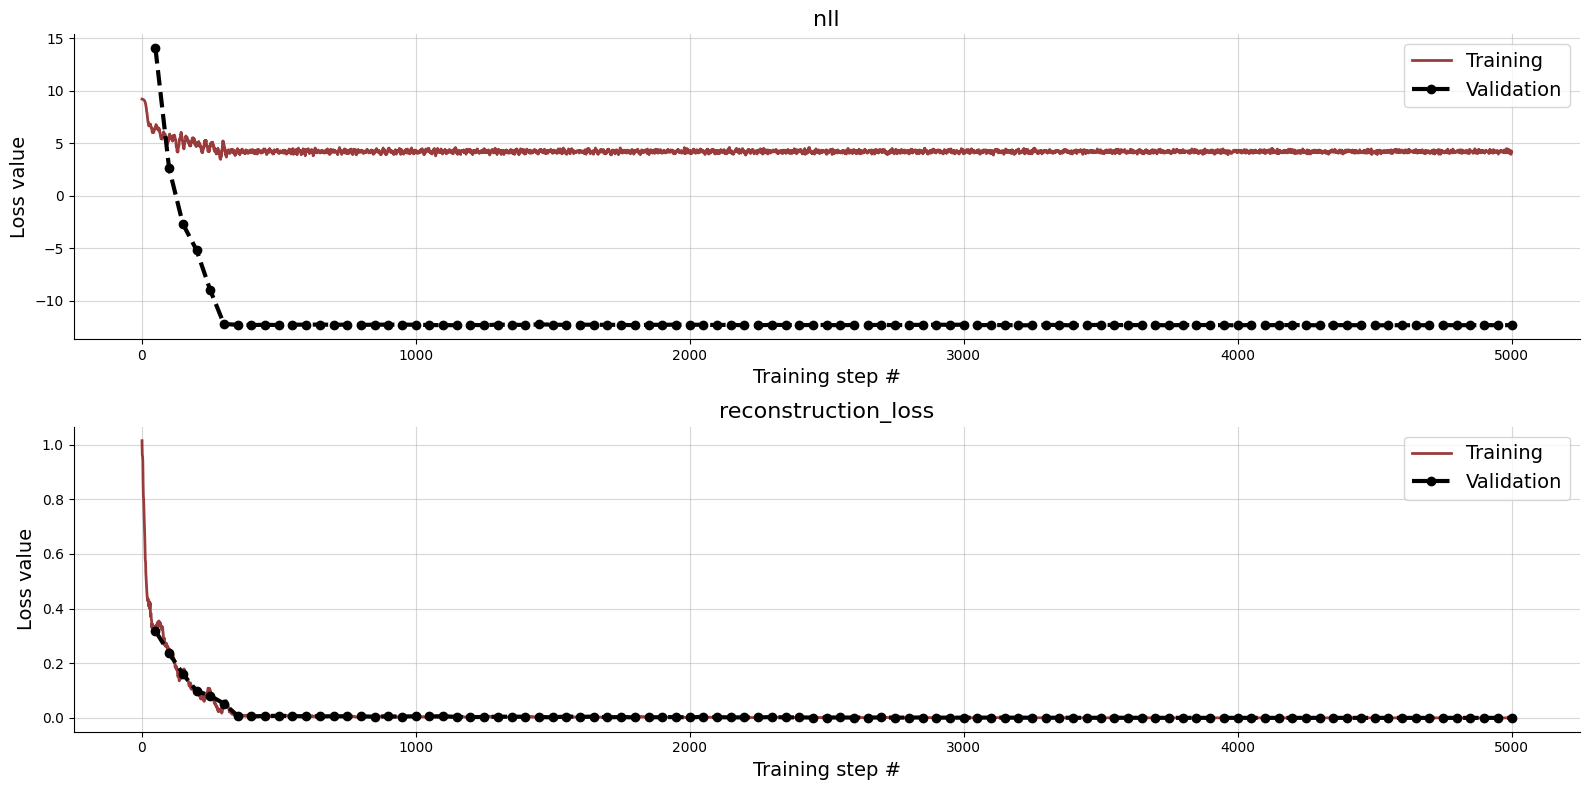

In [12]:
f = diagnostics.plot_losses(h['train_losses'], h['val_losses'], log_scale=False)

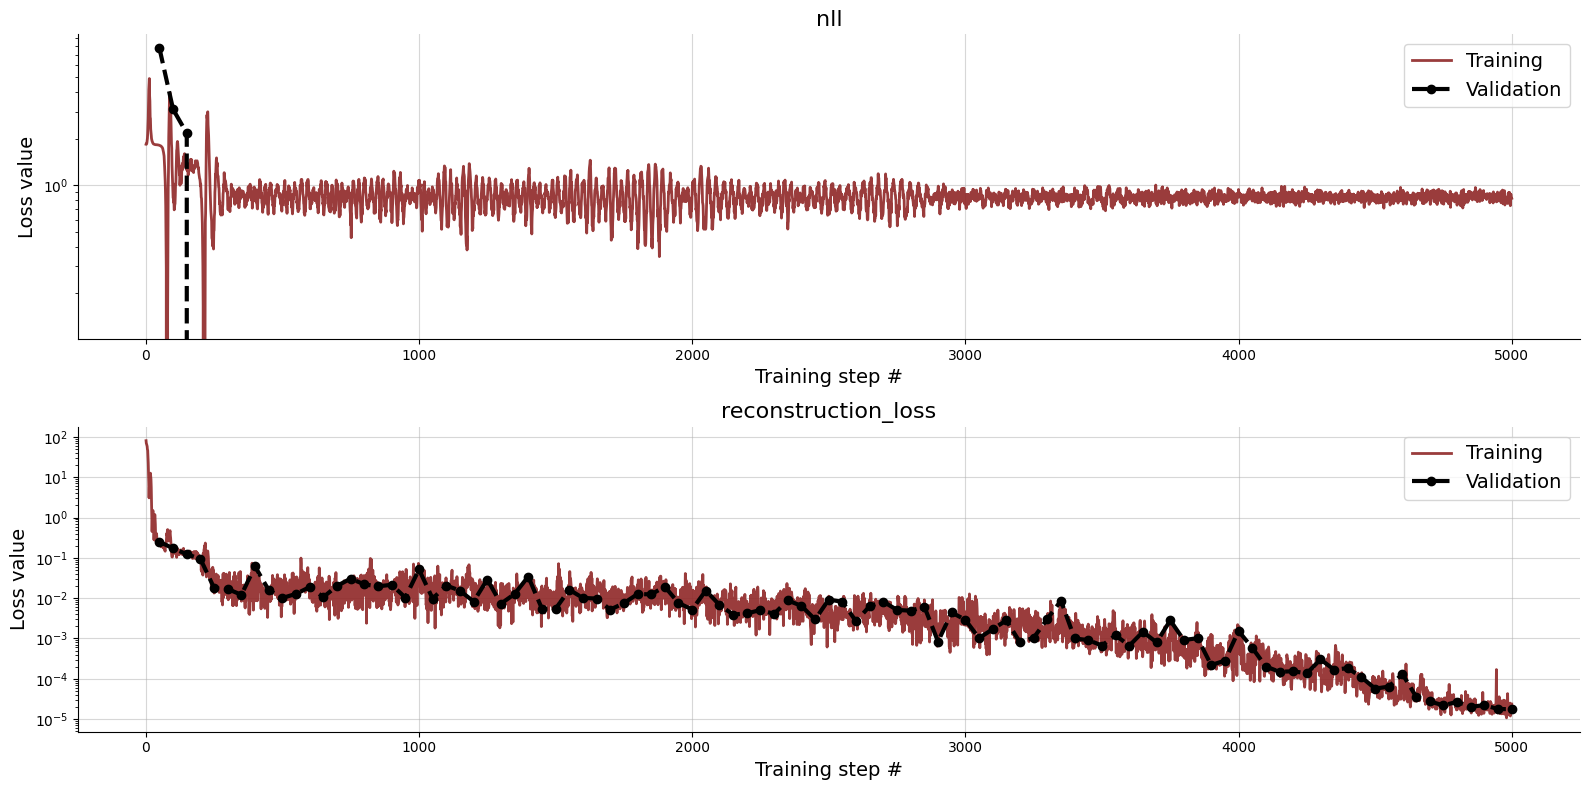

In [11]:
f = diagnostics.plot_losses(h['train_losses'], h['val_losses'], log_scale=True)

In [13]:
amortizer.inference_net.summary()

Model: "fff_network_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            multiple                  5376      
                                                                 
 dense_72 (Dense)            multiple                  65792     
                                                                 
 residual_block_20 (Residua  multiple                  131584    
 lBlock)                                                         
                                                                 
 residual_block_22 (Residua  multiple                  131584    
 lBlock)                                                         
                                                                 
 dense_82 (Dense)            multiple                  2570      
                                                                 
 dense_71 (Dense)            multiple                

## Evaluate on test data

In [14]:
samples = benchmark.configurator(benchmark.generative_model(n_observations))
samples_list = [dict(zip(samples.keys(), values)) for values in zip(*samples.values())]
sample_posterior = amortizer.sample_loop(samples_list, n_samples=n_samples)
samples_l = benchmark.configurator(benchmark.generative_model(n_latent))
sample_latent = amortizer.inference_net(samples_l['parameters'], samples_l['direct_conditions'])

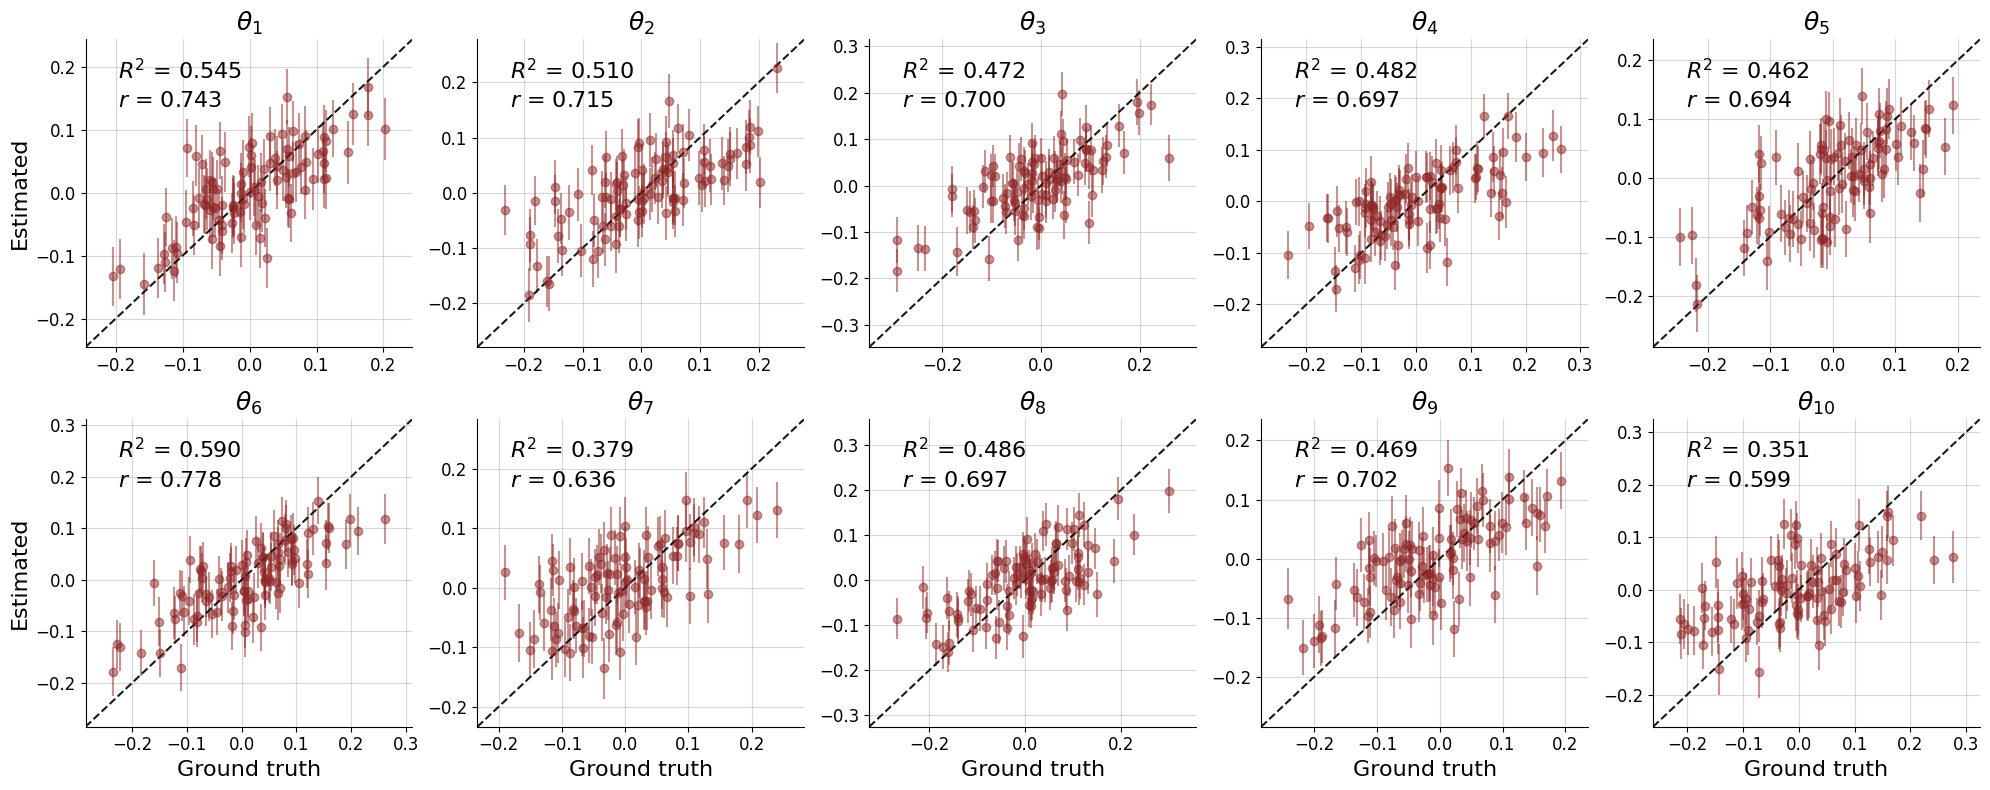

In [16]:
f = diagnostics.plot_recovery(sample_posterior, samples['parameters'])

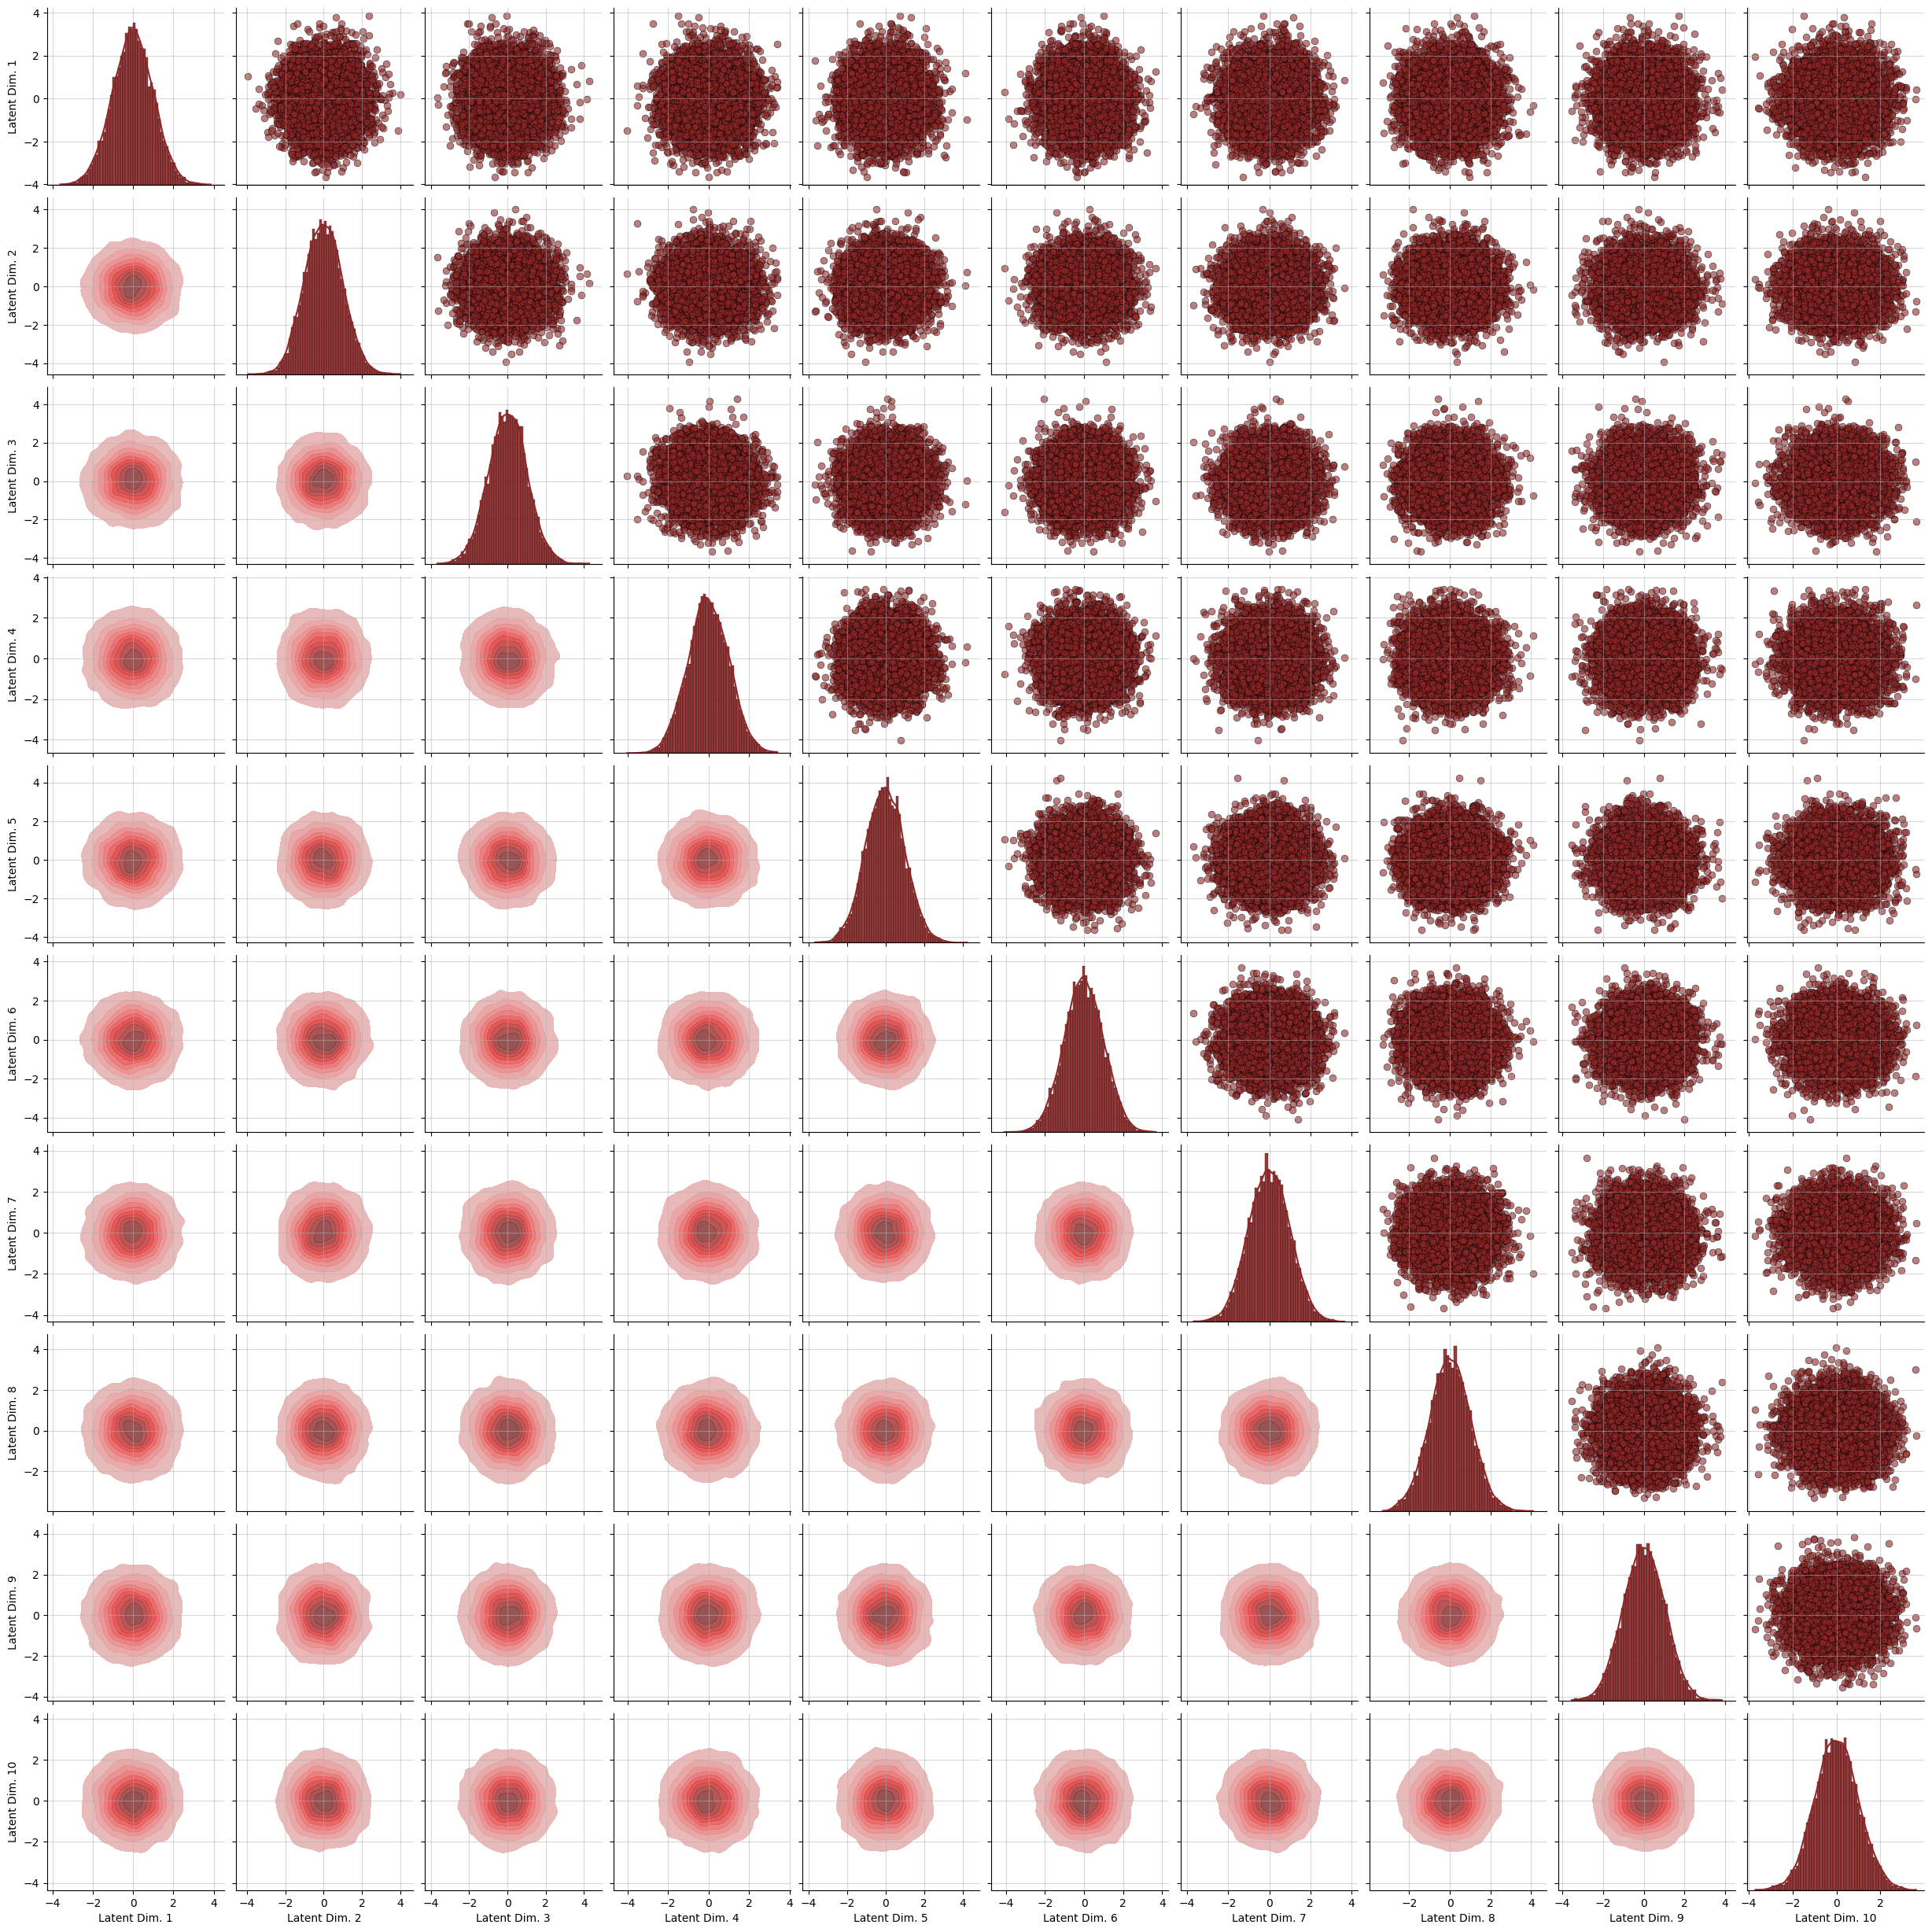

In [17]:
f = diagnostics.plot_latent_space_2d(sample_latent)

In [18]:
print('mean: ', np.mean(sample_latent, axis=0))
print('std: ', np.std(sample_latent, axis=0))

mean:  [-0.02076099 -0.00446133  0.02168095 -0.00077009 -0.01530403 -0.00907961
 -0.00277926  0.01505884  0.01292733  0.00582759]
std:  [1.0085446  0.9919588  1.0060219  1.0037767  1.0015491  1.0050576
 0.9896257  1.0112427  1.0123059  0.99703467]


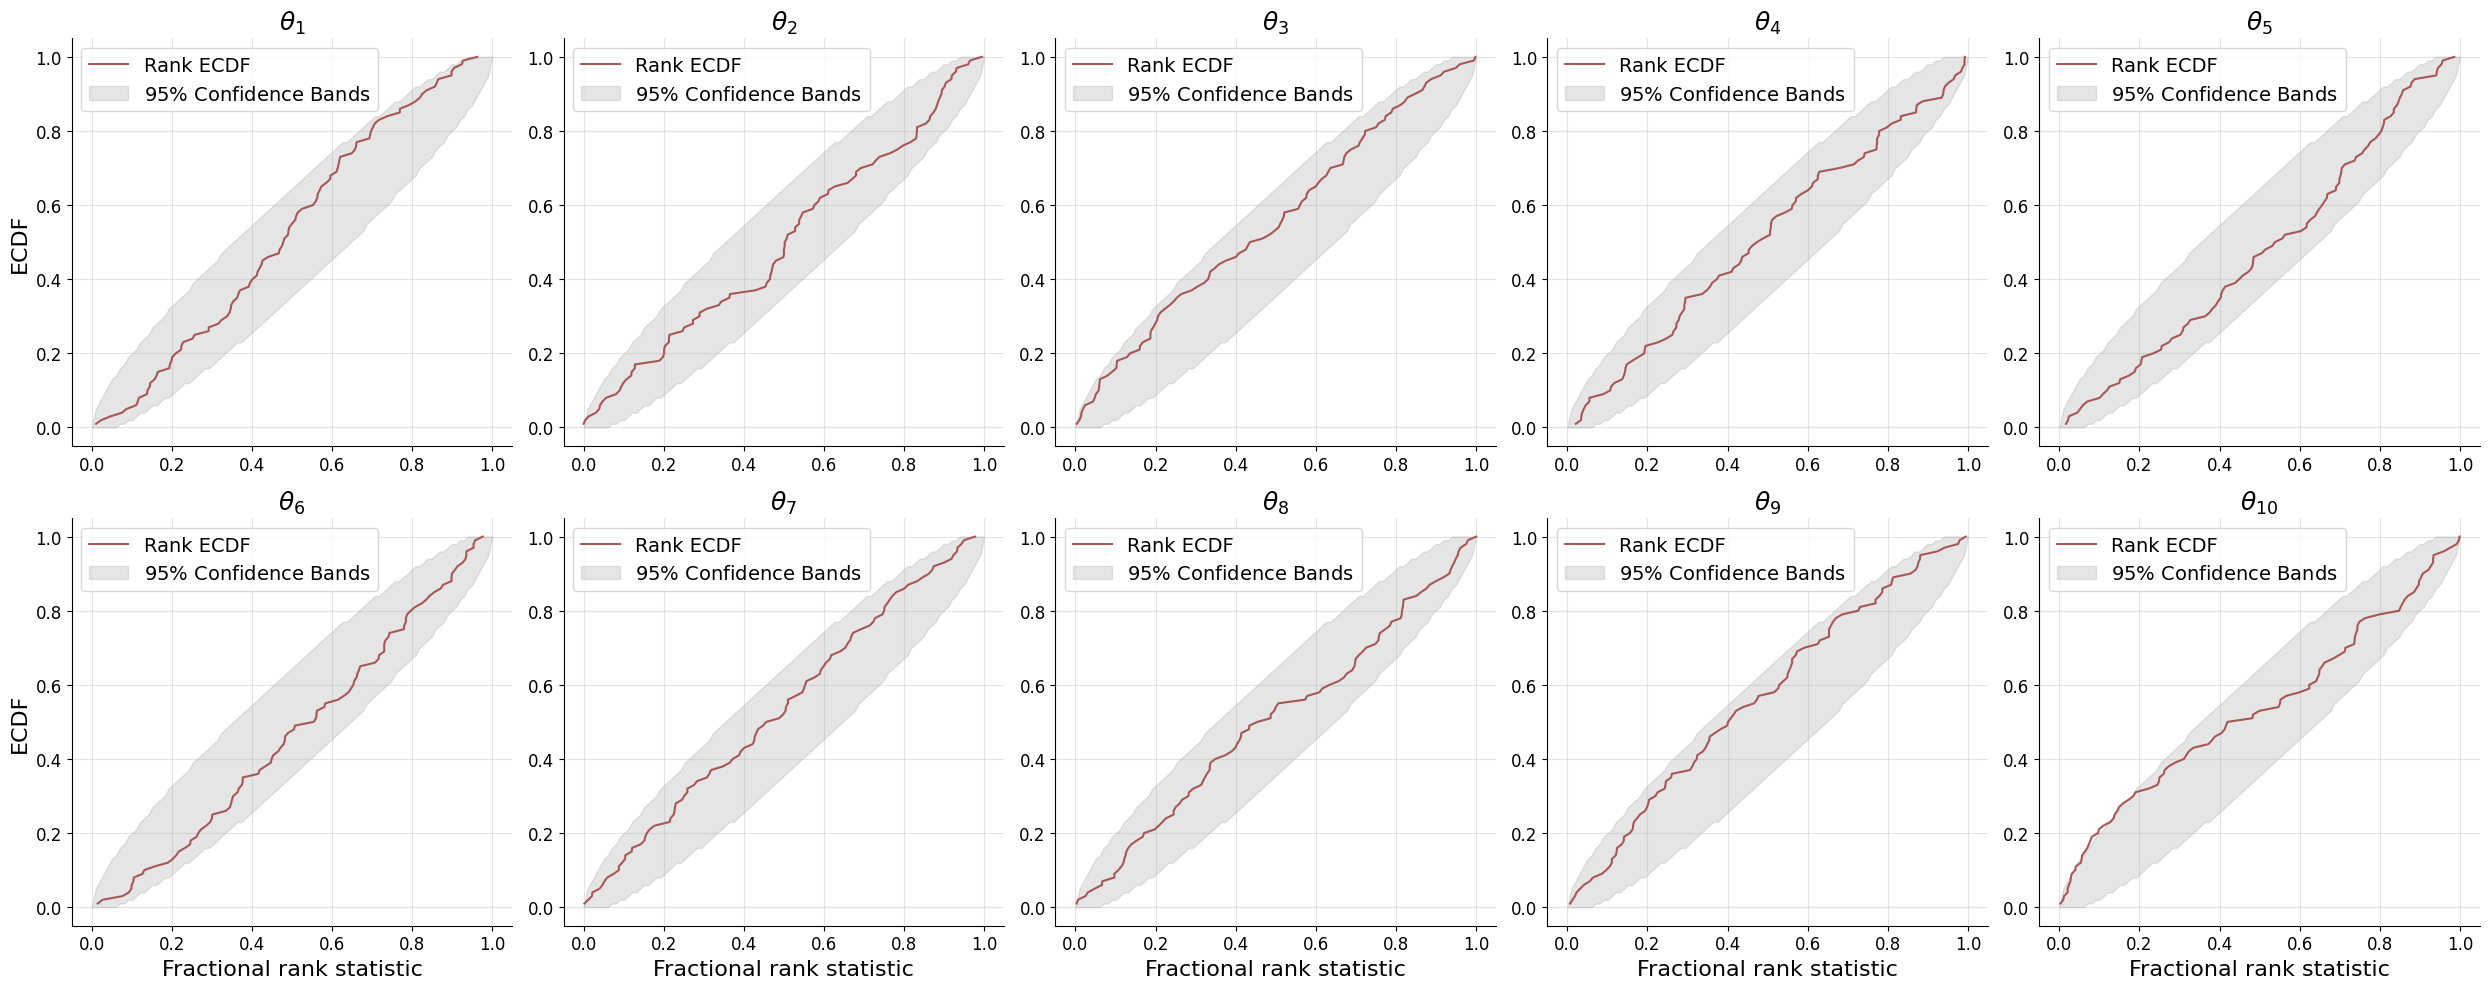

In [19]:
fig = diagnostics.plot_sbc_ecdf(sample_posterior, samples['parameters'])